In [305]:
%%capture
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../statnlpbook/")
#import util
import ie
import tfutil
import random
import numpy as np
import tensorflow as tf
np.random.seed(1337)
tf.set_random_seed(1337)

#util.execute_notebook('relation_extraction.ipynb')

In [306]:
%%HTML
<style>
.rendered_html td {
    font-size: x-large;
    text-align: left; !important
}
.rendered_html th {
    font-size: x-large;
    text-align: left; !important
}
</style>

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\a}{\alpha}
\newcommand{\b}{\beta}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Relation Extraction

## Goal of Lecture 

* NLP course so far: 
    * NLP as supervised learning
    * Unsupervised training
    * Representation learning
    * Decoding
    * Features for NLP tasks
* This lecture
    * Supervised approaches revisited
    * Weak supervision
    * Application task: relation extraction

##  Relation Extraction: Motivation 

* The amount of available information is growing exponentially
* Text contains a lot of information
* Only some of information is relevant for each use case
* How can we automatically make sense of information?

**Information Extraction** addresses this

[Alchemy information extraction demo](https://alchemy-language-demo.mybluemix.net/)

[ReVerb demo](http://openie.allenai.org/)

Relation extraction is relevant for many high-level NLP tasks, such as
* question answering
* information retrieval
* text and data mining

## Subtasks of Information Extraction

* **Document** Classification:
    * Assign a label to each document, often representing the topic
    * Often treated as standard [classification task](chapters/doc_classify.ipynb)
* **Named Entity Recognition (NER)**:
    * Recognise boundaries of entities in text, e.g. "New York", "New York Times" 
* **Named Entity Classification (NEC)**:
    * Assign a type to each entity (e.g. "New York" -> LOC, "New York Times" -> ORG)

## Named Entity Recognition and Classification
   
* NER and NEC are often approached together (NERC)
* They are often treated as a [sequence labelling task](chapters/sequence_labelling.ipynb)
* Every token is assigned 
    * a training label (e.g. PER)
    * and sometimes a positional tag (e.g. begininning of sequence (B), inside sequence (I), outside sequence (O)
* At test time, subsequent tokens with the same label are merged to one sequence

## Named Entity Recognition and Classification: Example
   

| Isabelle | Augenstein | is | an | assistant | professor | at | the | University | of | Copenhagen | 
|-|-|-|-|-|-|-|-|-|
| B-PER | I-PER   | O | O | O  | O | O  | O | B-LOC | I-LOC | I-LOC         | 

  Isabelle Augenstein: PER  
  University of Copenhagen: LOC  

## Subtasks of Information Extraction

* **Relation** Extraction:
    * Recognise relations between entities, e.g. "Isabelle Augenstein asst.prof-at KU"
    * classification task

* **Temporal** Information Extraction:
    * Recognise and/or normalise temporal expressions, e.g. "tomorrow morning at 8" -> "2016-11-26 08:00:00"
    * sequence labelling or generation task

## Subtasks of Information Extraction

* **Event** Extraction:
    * Recognise events, typically consisting of entities and relations between them at a point in time and place, e.g. an election
    * classification task

### Relation Extraction

Task of extracting **semantic relations between arguments**
* Arguments are entities
    * general concepts such as "a company" (ORG), "a person" (PER), "a location" (LOC)
    * instances of such concepts (e.g. "Microsoft", "Bill Gates"), i.e. named entitites (NEs)
* Relation extraction builds on the task of named entity recognition

### Relation Extraction: Example
   
Step 1: Sequence labelling

| Isabelle | Augenstein | is | an | assistant | professor | at | the | University | of | Copenhagen | 
|-|-|-|-|-|-|-|-|-|
| B-PER | I-PER   | O | O | O  | O | O  | O | B-LOC | I-LOC | I-LOC         | 


Step 2: NE decoding
  
  * Isabelle Augenstein: PER  
  * University of Copenhagen: LOC  

Step 3: Relation extraction
  
  
| Relation   | Entity 1    |Entity 2    |
|---------|-----------|-----------|
| assistant professor at  | Isabelle Augenstein | University of Copenhagen |

## Relation Extraction and Knowledge Bases

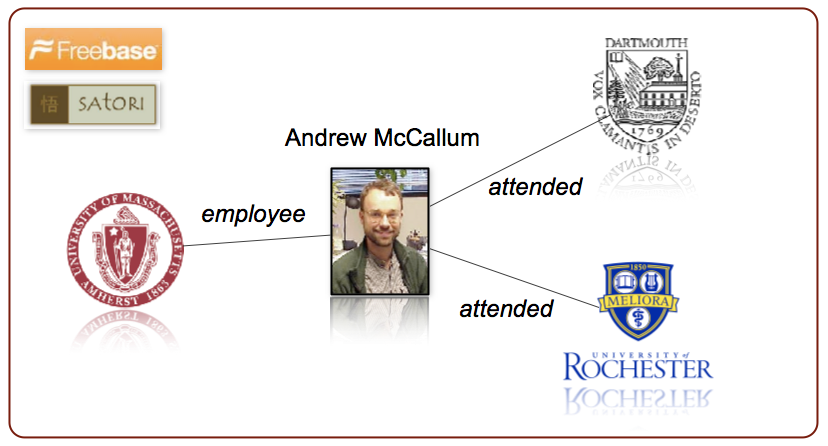

## Relation Extraction and Knowledge Bases

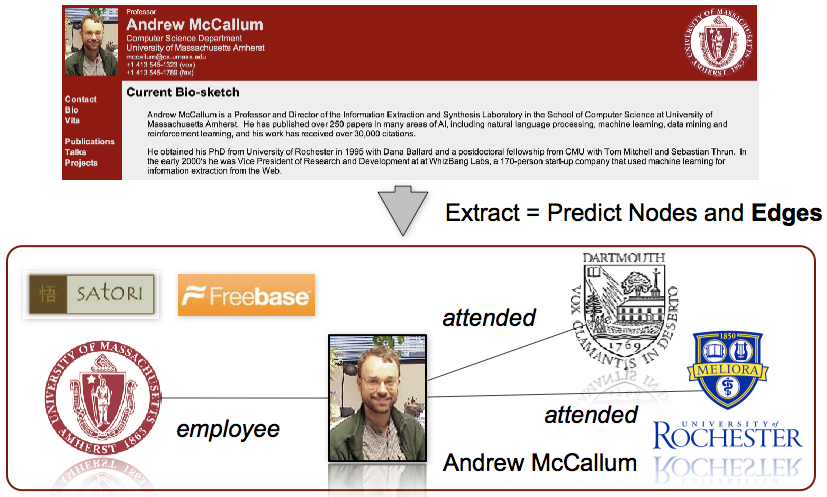

## Relation Extraction and Knowledge Bases: Biomedical Processes

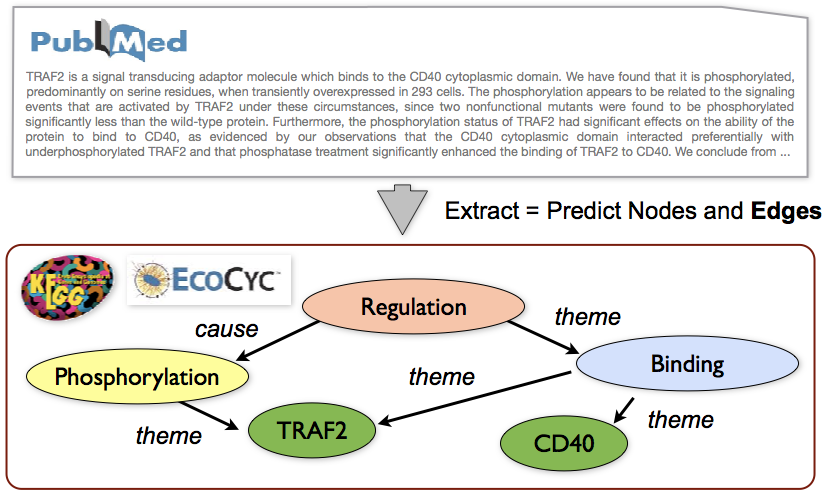

## Relation Extraction and Knowledge Bases: Drug-Gene Interactions

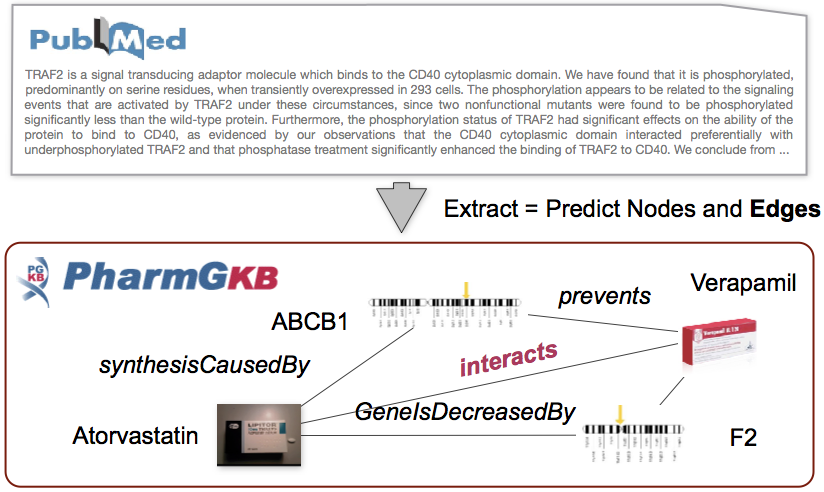

## Relation Extraction as Structured Prediction
We can formalise relation extraction as an instance of [structured prediction](chapters/structured_prediction.ipynb)
* Input space $\mathcal{X}$: pairs of arguments $\mathcal{E}$ and supporting texts $\mathcal{S}$
* Output space $\mathcal{Y}$: set of relation labels, e.g. $\Ys=\{ \text{founder-of},\text{employee-at},\text{professor-at},\text{NONE}\}$

## Relation Extraction as Structured Prediction
* **Goal**: train model \\(s_{\params}(\x,y)\\) that assigns high *scores* to the label $\mathcal{y}$ that fits the arguments and supporting text $\mathcal{\x}$, low scores otherwise 
* **Training**: Learn parameters \\(\params\\) from training set of $\mathcal{\x,y}$ pairs
* **Prediction** of labels for input instances $\mathcal{\x}$: solve maximisation problem $\argmax_y s_{\params}(\x,y)$.


<img src="dl-applications-figures/WS_mapping.png" width=800/> 

Source: https://hazyresearch.github.io/snorkel/blog/ws_blog_post.html

## Relation Extraction Approaches
* **Pattern-Based** Relation Extraction:
    * Extract relations via manually defined textual patterns
* **Bootstrapping**:
    * Iterative pattern-based relation extraction

* **Supervised** Relation Extraction:
    * Train supervised model from manually labelled training examples
* **Distantly Supervised** Relation Extraction:
    * Supervised model with automatically annotated training data

* **Universal Schema** Relation Extraction:
    * Model relation types and surface forms in same semantic space
* **Transfer Learning** for Relation Extraction:
    * Use word or sentence embeddings trained on larger dataset, see representation learning lecture slides ([intro](dl-representations.ipynb), [language models](language_models_slides.ipynb), [RNN applications](rnn_slides_ucph.ipynb))


## Relation Extraction: Running Example
* Extracting "method used for task" relations from sentences in computer science publications
* The first step would normally be to detect pairs of arguments $\mathcal{E}$. For simplicity, our training data already contains those annotations.


## Pattern-Based Extraction
* The simplest relation extraction method
* Set of textual patterns for each relation
* Assign labels to entity pairs whose sentences match that pattern
    * Labels: relation types or "NONE"
* Data: entity pairs $\mathcal{E}$, patterns $A$, labels $Y$

In [307]:
training_patterns, training_entpairs = ie.readLabelledPatternData()
# Training patterns and entity pairs for relation 'method used for task'
[(tr_a, tr_e) for (tr_a, tr_e) in zip(training_patterns[:3], training_entpairs[:3])]

[('demonstrates XXXXX and clustering techniques for XXXXX',
  ['text mining', 'building domain ontology']),
 ('demonstrates text mining and XXXXX for building XXXXX',
  ['clustering techniques', 'domain ontology']),
 ('the XXXXX is able to enhance the XXXXX',
  ['ensemble classifier', 'detection of construction materials'])]

* Patterns: sentences where entity pairs are blanked with placeholder 'XXXXX'
* Here: 
    * Only one relation, 'method used for task'
    * Manually defined patterns
* Labels for training data, no labels for test data
* Task: 'predict' labels for test data

In [308]:
testing_patterns, testing_entpairs = ie.readPatternData()
# Testing patterns and entity pairs
[(tr_a, tr_e) for (tr_a, tr_e) in zip(testing_patterns[0:3], testing_entpairs[:3])]

[('a method for estimation of XXXXX of XXXXX is presented',
  ['effective properties', 'porous materials']),
 ('accounting for XXXXX is essential for estimation of XXXXX',
  ['nonlinear effects', 'effective properties']),
 ('develops the heterogeneous XXXXX for fiber-reinforced XXXXX',
  ['feature model', 'object modeling'])]

**Scoring model**: determine which instance belongs to which relation
  * A pattern scoring model \\(s_{\params}(\x,y)\\) only has one parameter
  * Assignes scores to each relation label \\(y\\) proportional to the matches with the set of textual patterns
  * The final label assigned to each instance is then the one with the highest score

* Here, our pattern scoring model is even simpler since we only have patterns for one relation
    * Final label: 'method used for task' if there is a match with a pattern, 'NONE' if no match

### Closer look at pattern matching
* Patterns in the training data: sentences where entity pairs are blanked with 'XXXXX'
* Suggested improvement:
    * We could use those patterns to find more sentences
    * However, we are not likely to find many since patterns are very specific to the example
* We need to **generalise** those patterns to less specific ones
    * e.g. define sequence of words between each entity pair as a pattern

In [309]:
def sentenceToShortPath(sent):
    """
    Returns the path between two arguments in a sentence, where the arguments have been masked
    Args:
        sent: the sentence
    Returns:
        the path between to arguments
    """
    sent_toks = sent.split(" ")
    indeces = [i for i, ltr in enumerate(sent_toks) if ltr == "XXXXX"]
    pattern = " ".join(sent_toks[indeces[0]+1:indeces[1]])
    return pattern

print(training_patterns[0])
sentenceToShortPath(training_patterns[0])

demonstrates XXXXX and clustering techniques for XXXXX


'and clustering techniques for'

* There are many different alternatives to this method for shortening patterns
* **Thought exercise**: 
    * what is a possible problem with this way of shortening patterns and what are better ways of generalising patterns?
    
Enter answer: https://tinyurl.com/y5y9fwpe

### Revised pattern extraction approach
  * Define sentence shortening / **pattern generalisation method**
  * Apply patterns to testing instances to classify them into 'method used for task' and 'NONE'

Example: return instances which contain a 'method used for task' pattern

In [310]:
def patternExtraction(training_sentences, testing_sentences):
    """
    Given a set of patterns for a relation, searches for those patterns in other sentences
    Args:
        sent: training sentences with arguments masked, testing sentences with arguments masked
    Returns:
        the testing sentences which the training patterns appeared in
    """
    # convert training and testing sentences to short paths to obtain patterns
    training_patterns = set([sentenceToShortPath(train_sent) for train_sent in training_sentences])
    testing_patterns = [sentenceToShortPath(test_sent) for test_sent in testing_sentences]
    # look for match of training and testing patterns
    testing_extractions = []
    for i, testing_pattern in enumerate(testing_patterns):
        if testing_pattern in training_patterns: # look for exact matches of patterns
            testing_extractions.append(testing_sentences[i])
    return testing_extractions

patternExtraction(training_patterns[:300], testing_patterns[:300])

['paper reviews applications of XXXXX in XXXXX',
 'a novel approach was developed to determine the XXXXX in XXXXX',
 'four different types of insoles were examined in terms of their effects on XXXXX in XXXXX',
 'the findings can aid in better understanding the insole design features that could improve XXXXX in XXXXX',
 'this new approach provides more degrees of freedom and XXXXX in XXXXX']

* Problems with approach: 
    * set of patterns has to be defined manually
    * the model does not learn new patterns
    

* Next: approach which addresses those two shortcomings


## Bootstrapping

* Input: a set of entity pairs
* Overall idea: extract patterns and entity pairs **iteratively**
* One of the first algorithms: [DIPRE (Sergey Brin, 1999)](http://ilpubs.stanford.edu:8090/421/1/1999-65.pdf)
* Two helper methods: 
    * *use entity pairs* to find/generate (more) patterns
    * *apply patterns* to find entity pairs


In [311]:
# use entity pairs to find more patterns
def searchForEntpairsByPatterns(training_patterns, testing_patterns, testing_entpairs, testing_sentences):
    testing_extractions = []
    appearing_testing_patterns = []
    appearing_testing_entpairs = []
    for i, testing_pattern in enumerate(testing_patterns):
        if testing_pattern in training_patterns: # if there is an exact match of a pattern
            testing_extractions.append(testing_sentences[i])
            appearing_testing_patterns.append(testing_pattern) # add that pattern
            appearing_testing_entpairs.append(testing_entpairs[i])
    return testing_extractions, appearing_testing_patterns, appearing_testing_entpairs

In [312]:
# use patterns to find entity pairs
def searchForPatternsByEntpairs(training_entpairs, testing_patterns, testing_entpairs, testing_sentences):
    testing_extractions = []
    appearing_testing_patterns = []
    appearing_testing_entpairs = []
    for i, testing_entpair in enumerate(testing_entpairs):
        if testing_entpair in training_entpairs: # if there is an exact match of an entity pair
            testing_extractions.append(testing_sentences[i])
            appearing_testing_entpairs.append(testing_entpair) # add that entity pair
            appearing_testing_patterns.append(testing_patterns[i])
    return testing_extractions, appearing_testing_patterns, appearing_testing_entpairs

The two helper functions are then applied iteratively:

In [313]:
def bootstrappingExtraction(train_sents, train_entpairs, test_sents, test_entpairs, num_iter=10):
    """
    Given a set of patterns and entity pairs for a relation, extracts more patterns and entity pairs iteratively
    Args:
        train_sents: training sentences with arguments masked
        train_entpairs: training entity pairs
        test_sents: testing sentences with arguments masked
        test_entpairs: testing entity pairs
    Returns:
        the testing sentences which the training patterns or any of the inferred patterns appeared in
    """

In [314]:
def bootstrappingExtraction(train_sents, train_entpairs, test_sents, test_entpairs, num_iter=10):
    # convert training and testing sentences to short paths to obtain patterns
    train_patterns = set([sentenceToShortPath(s) for s in train_sents])
    #train_patterns.discard("in") # too general, remove this
    test_patterns = [sentenceToShortPath(s) for s in test_sents]

    # iteratively get more patterns and entity pairs
    for i in range(1, num_iter):
        print("Number extractions at iteration", str(i), ":", str(len(test_extracts)))
        print("Number patterns at iteration", str(i), ":", str(len(train_patterns)))
        print("Number entpairs at iteration", str(i), ":", str(len(train_entpairs)))
        # get more patterns and entity pairs
        test_extracts_e, ext_test_patterns_e, ext_test_entpairs_e = searchForPatternsByEntpairs(train_entpairs, test_patterns, test_entpairs, test_sents)
        test_extracts_p, ext_test_patterns_p, ext_test_entpairs_p = searchForEntpairsByPatterns(train_patterns, test_patterns, test_entpairs, test_sents)
        # add them to the existing entity pairs for the next iteration
        train_patterns.update(ext_test_patterns_p)
        train_patterns.update(ext_test_patterns_e)
        train_entpairs.extend(ext_test_entpairs_p)
        train_entpairs.extend(ext_test_entpairs_e)
        test_extracts.extend(test_extracts_p)
        test_extracts.extend(test_extracts_e)

    return test_extracts, test_entpairs, train_patterns

In [315]:
test_extracts, test_entpairs, train_patterns = bootstrappingExtraction(training_patterns[:20], training_entpairs[:20], testing_patterns, testing_entpairs, 10)

Number extractions at iteration 1 : 14537
Number patterns at iteration 1 : 19
Number entpairs at iteration 1 : 20
Number extractions at iteration 2 : 14615
Number patterns at iteration 2 : 19
Number entpairs at iteration 2 : 98
Number extractions at iteration 3 : 14776
Number patterns at iteration 3 : 24
Number entpairs at iteration 3 : 259
Number extractions at iteration 4 : 14942
Number patterns at iteration 4 : 24
Number entpairs at iteration 4 : 425
Number extractions at iteration 5 : 15108
Number patterns at iteration 5 : 24
Number entpairs at iteration 5 : 591
Number extractions at iteration 6 : 15274
Number patterns at iteration 6 : 24
Number entpairs at iteration 6 : 757
Number extractions at iteration 7 : 15440
Number patterns at iteration 7 : 24
Number entpairs at iteration 7 : 923
Number extractions at iteration 8 : 15606
Number patterns at iteration 8 : 24
Number entpairs at iteration 8 : 1089
Number extractions at iteration 9 : 15772
Number patterns at iteration 9 : 24
Num

Problem: 
* with each iteration, the number of pattern, entity pairs and extractions increases
* however, they are less correct

In [316]:
# patterns that do not co-occur with first set of entity pairs
for p in train_patterns:
    if p not in set([sentenceToShortPath(s) for s in training_patterns[:20]]):
        print(p)

is higher in
is proposed to plan and execute task in
and finally to illustrate the applicability of the proposed method , a
is introduced in
is firstly introduced in


* One of the reasons is that the semantics of the pattern shifts ("**semantic drift**")
    * here we try to find new patterns for 'method used for task'
    * but because the instances share a similar context with other relations, the patterns and entity pairs iteratively move away from the 'method used in task' relation
    * Another example: 'employee-at', 'student-at' -> many overlapping contexts


* One solution: confidence values for each entity pair and pattern
    * E.g., we might want to avoid entity pairs or patterns which are too general and penalise them

In [317]:
from collections import Counter
te_cnt = Counter()
for te in test_extracts:
    te_cnt[sentenceToShortPath(te)] += 1
print(te_cnt)

Counter({'in': 13706, 'to solve a': 767, 'is proposed to solve the': 645, 'is firstly introduced in': 164, 'is introduced in': 164, 'and finally to illustrate the applicability of the proposed method , a': 164, 'is proposed to plan and execute task in': 164, 'is higher in': 164})


* Such a 'noisy' pattern is e.g. 'in': it matches many contexts that are not 'method used for task' 
* **Thought exercise**: 
    * how would a confidence weighting for patterns work here?
    
Enter answer: https://tinyurl.com/y3dxzjuz

## Supervised Relation Extraction
* Follow the supervised learning paradigm
    * We have already seen for other structured prediction tasks
* Scoring model \\(s_{\params}(\x,y)\\) is estimated based on training sentences $\mathcal{X}$ and their labels $\mathcal{Y}$
* We can use range of different classifiers, e.g. a logistic regression model or an SVM
* At testing time, the predict highest-scoring label for each testing instance, i.e. $$ \y^* = \argmax_{\y\in\Ys} s(\x,\y) $$


### Example
* The training data consists again of patterns, entity pairs and labels
* This time, the given labels for the training instances are 'method used for task' or 'NONE', i.e. we have positive and negative training data

In [318]:
training_sents, training_entpairs, training_labels = ie.readLabelledData()
print("Manually labelled data set consists of", training_labels.count("NONE"), 
          "negative training examples and", training_labels.count("method used for task"), "positive training examples\n")
for (tr_s, tr_e, tr_l) in zip(training_sents[:3], training_entpairs[:3], training_labels[:3]):
    print(tr_s, tr_e, tr_l)

Manually labelled data set consists of 22 negative training examples and 22 positive training examples

demonstrates XXXXX and clustering techniques for XXXXX ['text mining', 'building domain ontology'] method used for task
demonstrates text mining and XXXXX for building XXXXX ['clustering techniques', 'domain ontology'] method used for task
the XXXXX is able to enhance the XXXXX ['ensemble classifier', 'detection of construction materials'] method used for task


Feature extraction
* Transform training and testing data to features 
* Typical features: shortest dependency path between two entities (see [parsing slides](dependency_parsing_slides.ipynb))
* We assume again that entity pairs are already recognised

* Example shown with sklearn's built-in feature extractor to transform sentences to n-grams

In [319]:
from sklearn.feature_extraction.text import CountVectorizer

def featTransform(sents_train, sents_test):
    cv = CountVectorizer()
    cv.fit(sents_train)
    print(cv.get_params())
    features_train = cv.transform(sents_train)
    features_test = cv.transform(sents_test)
    return features_train, features_test, cv

Define a model, here: sklearn, using one of their built-in classifiers and a prediction function

In [320]:
from sklearn.linear_model import LogisticRegression

def model_train(feats_train, labels):
    model = LogisticRegression(penalty='l2')  # logistic regression model with l2 regularisation
    model.fit(feats_train, labels) # fit the model to the transformed training data
    return model

def predict(model, features_test):
    """Find the most compatible output class"""
    preds = model.predict(features_test) # this returns the predicted labels
    #preds_prob = model.predict_proba(features_test)  # this returns probablities instead of labels
    return preds

Helper function for debugging that determines the most useful features learned by the model

In [321]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

Supervised relation extraction algorithm:

In [322]:
def supervisedExtraction(train_sents, train_entpairs, train_labels, test_sents, test_entpairs):
    """
    Given pos/neg training instances, train a logistic regression model with simple BOW features and predict labels on unseen test instances
    Args:
        train_sents: training sentences with arguments masked
        train_entpairs: training entity pairs
        train_labels: labels of training instances
        test_sents: testing sentences with arguments masked
        test_entpairs: testing entity pairs
    Returns:
        predictions for the testing sentences
    """

In [323]:
def supervisedExtraction(train_sents, train_entpairs, train_labels, test_sents, test_entpairs):

    # convert training and testing sentences to short paths to obtain patterns
    train_patterns = [sentenceToShortPath(test_sent) for test_sent in train_sents]
    test_patterns = [sentenceToShortPath(test_sent) for test_sent in test_sents]

    # extract features
    features_train, features_test, cv = featTransform(train_patterns, test_patterns)

    # train model
    model = model_train(features_train, train_labels)

    # show most common features
    show_most_informative_features(cv, model)

    # get predictions
    predictions = predict(model, features_test)

    # show the predictions
    for tup in zip(predictions, test_sents, test_entpairs):
        print(tup)

    return predictions

In [324]:
supervisedExtraction(training_sents, training_entpairs, training_labels, testing_patterns, testing_entpairs)

{'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
	-0.9520	of             		1.0542	is             
	-0.4352	specified      		0.9787	to             
	-0.4352	using          		0.8733	for            
	-0.4313	ann            		0.4851	and            
	-0.4313	find           		0.4785	solved         
	-0.3274	decreases      		0.4785	assists        
	-0.3258	that           		0.4309	are            
	-0.3181	allowing       		0.4151	solve          
	-0.3181	except         		0.4081	on             
	-0.3074	as             		0.4081	application    
	-0.2935	in             		0.3915	more           
	-0.2892	introduced     		0.3915	capable        
	-0.2892	unified        		0.3526	presente

('method used for task', 'we use an improved multiobjective estimation of XXXXX ( irm-meda ) to solve the environmental economic dispatch of hydrothermal XXXXX', ['power systems', 'distribution algorithm'])
('method used for task', 'the proposed algorithm obtained new optimal solutions and XXXXX for XXXXX', ['upper bounds', 'benchmark problems'])
('NONE', 'a new method of XXXXX of the generalized XXXXX', ['similarity measure', 'trapezoidal fuzzy numbers'])
('method used for task', 'combining ga and tmvdr achieve XXXXX and XXXXX', ['high accuracy', 'fast convergence'])
('NONE', 'to our knowledge , it was the first study in identifying the XXXXX with XXXXX', ['computer vision', 'butterfly species'])
('method used for task', 'the method is based on XXXXX and XXXXX', ['local binary patterns', 'artificial neural network'])
('method used for task', "a novel XXXXX based on improved culture algorithm for a vehicle 's active suspension was proposed and supported by XXXXX", ['control strategy', 

('NONE', 'social-spider optimization for XXXXX in XXXXX', ['model selection', 'support vector machines'])
('method used for task', 'minimal added XXXXX needed to expand the score and avoid XXXXX', ['time complexity', 'information loss'])
('method used for task', 'multi-level XXXXX is proposed to enhance XXXXX of lbp', ['discrimination power', 'quantization scheme'])
('method used for task', 'a XXXXX is preprocessed to produce a XXXXX object and a blur image object', ['test image', 'noise image'])
('method used for task', 'a XXXXX is preprocessed to produce a noise XXXXX and a blur XXXXX', ['test image', 'image object'])
('method used for task', 'a test image is preprocessed to produce a XXXXX object and a blur XXXXX', ['noise image', 'image object'])
('method used for task', 'a new energy efficient XXXXX has been proposed for cluster based XXXXX', ['routing algorithm', 'wireless sensor networks'])
('method used for task', 'seed achieves o ( 1 ) message exchange complexity per XXXXX and

('method used for task', 'XXXXX is a method called numerical microscope in signal processing and XXXXX', ['wavelet analysis', 'numerical analysis'])
('method used for task', 'wavelet analysis is a method called numerical microscope in XXXXX and XXXXX', ['signal processing', 'numerical analysis'])
('NONE', 'an efficient XXXXX of 3d semi-rigid XXXXX is proposed', ['steel frames', 'analysis procedure'])
('method used for task', 'a XXXXX to address uncertainty effects in the XXXXX is presented', ['hybrid method', 'impact force identification'])
('method used for task', 'a XXXXX is conducted to analyze the effects of material uncertainty on XXXXX of composite stiffened panels', ['parametric study', 'dynamic responses'])
('NONE', 'influence of the XXXXX kinetics was taken into account by implementing in the fem model XXXXX data', ['phase transformation', 'phase transformation kinetics'])
('NONE', 'XXXXX procedure at XXXXX is based on diffuse approximation', ['field transfer', 'integration po

array(['NONE', 'method used for task', 'method used for task', ...,
       'method used for task', 'NONE', 'method used for task'], 
      dtype='<U20')

### Model Inspection
* Some the features are common words (i.e. 'stop words', such as 'is') and very broad
* Others are very specific and thus might not appear very often
* Typically these problems can be mitigated by using more involved features, e.g. based on syntax
* Current model ignores entity pairs, only featurises the path between the entity pairs
    * We will later examine a model that also takes entity pairs into account


* Finally, the model requires manually annotated training data, which might not always be available
* Next, we will look at a method that provides a solution for the latter

## Distant Supervision
* Supervised learning typically requires large amounts of hand-labelled training examples
* It is **time-consuming and expensive** to manually label examples
    * It is desirable to find ways of automatically or semi-automatically producing more training data
    * We have already seen one example of this, bootstrapping
* Downside of bootstrapping: **semantic drift** 
    * due to the iterative nature of finding good entity pairs and patterns
* Alternative: distant supervision

* We still have a set of entity pairs $\mathcal{E}$, their relation types $\mathcal{R}$ and a set of sentences $\mathcal{X}$ as an input
    * but we do **not require pre-defined patterns**
* Instead, entity pairs and relations are obtained from a **knowledge resource**, e.g. the [Wikidata knowledge base](https://www.wikidata.org), Yago or Freebase
* Those are used to automatically label all sentences with relations
* Afterwards: supervised learning

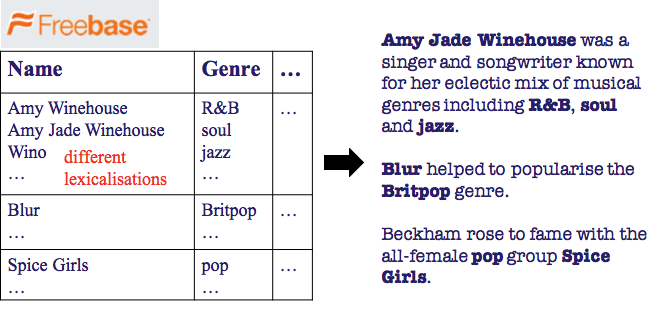

In [325]:
def distantlySupervisedLabelling(kb_entpairs, unlab_sents, unlab_entpairs):
    """
    Label instances using distant supervision assumption
    Args:
        kb_entpairs: entity pairs for a specific relation
        unlab_sents: unlabelled sentences with entity pairs anonymised
        unlab_entpairs: entity pairs which were anonymised in unlab_sents

    Returns: pos_train_sents, pos_train_enpairs, neg_train_sents, neg_train_entpairs

    """

In [326]:
def distantlySupervisedLabelling(kb_entpairs, unlab_sents, unlab_entpairs):
    train_sents, train_entpairs, train_labels = [], [], []
    for i, unlab_entpair in enumerate(unlab_entpairs):
        # if the entity pair is a KB tuple, it is a positive example for that relation
        if unlab_entpair in kb_entpairs:  
            train_entpairs.append(unlab_entpair)
            train_sents.append(unlab_sents[i])
            train_labels.append("method used for task")
        else: # else, it is a negative example for that relation
            train_entpairs.append(unlab_entpair)
            train_sents.append(unlab_sents[i])
            train_labels.append("NONE")

    return train_sents, train_entpairs, train_labels

In [327]:
def distantlySupervisedExtraction(kb_entpairs, unlab_sents, unlab_entpairs, test_sents, test_entpairs):
    # training_data <- Find training sentences with entity pairs
    train_sents, train_entpairs, train_labels = distantlySupervisedLabelling(kb_entpairs, unlab_sents, unlab_entpairs)
    
    print("Distantly supervised labelling results in", train_labels.count("NONE"), 
          "negative training examples and", train_labels.count("method used for task"), "positive training examples")
    
    # training works the same as for supervised RE
    supervisedExtraction(train_sents, train_entpairs, train_labels, test_sents, test_entpairs)

In [328]:
kb_entpairs, unlab_sents, unlab_entpairs = ie.readDataForDistantSupervision()
#print(len(kb_entpairs), "'KB' entity pairs for relation 'method used for task' :", kb_entpairs[0:5])
#print(len(unlab_entpairs), 'all entity pairs')
distantlySupervisedExtraction(kb_entpairs, unlab_sents, unlab_entpairs, testing_patterns, testing_entpairs)

Distantly supervised labelling results in 22 negative training examples and 22 positive training examples
{'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
	-0.9520	of             		1.0542	is             
	-0.4352	specified      		0.9787	to             
	-0.4352	using          		0.8733	for            
	-0.4313	ann            		0.4851	and            
	-0.4313	find           		0.4785	solved         
	-0.3274	decreases      		0.4785	assists        
	-0.3258	that           		0.4309	are            
	-0.3181	allowing       		0.4151	solve          
	-0.3181	except         		0.4081	on             
	-0.3074	as             		0.4081	application    
	-0.2935	in             		0.3915	

('method used for task', 'XXXXX and parameter tuning are conducted as a unifying XXXXX', ['feature selection', 'model selection'])
('NONE', 'feature selection and XXXXX are conducted as a unifying XXXXX', ['parameter tuning', 'model selection'])
('method used for task', 'we present a study about the performance of two classical weight training methods of XXXXX ( rbfn ) , least mean square ( lms ) and XXXXX ( svd ) , applied to classification problems , when the data-sets are imbalanced', ['radial basis function networks', 'singular value decomposition'])
('method used for task', 'we present a study about the performance of two classical weight training methods of XXXXX ( rbfn ) , least mean square ( lms ) and singular value decomposition ( svd ) , applied to XXXXX , when the data-sets are imbalanced', ['radial basis function networks', 'classification problems'])
('method used for task', 'we present a study about the performance of two classical weight training methods of radial basis 

('method used for task', 'the devised XXXXX is validated with XXXXX', ['finite element analysis', 'force system'])
('NONE', 'the XXXXX uses a bio-inspired XXXXX on the hermite transform to code local image features', ['optical flow estimation', 'model based'])
('method used for task', 'the XXXXX uses a bio-inspired model based on the hermite transform to code local XXXXX', ['optical flow estimation', 'image features'])
('method used for task', 'the optical flow estimation uses a bio-inspired XXXXX on the hermite transform to code local XXXXX', ['model based', 'image features'])
('NONE', 'the XXXXX allows an unprecedented XXXXX in cell dynamics', ['wavelet transform', 'multi-scale analysis'])
('method used for task', 'we used XXXXX and XXXXX for wheeze recognition', ['short-time fourier transform', 'svm classifier'])
('NONE', 'saccadic XXXXX could be detected efficiently by an XXXXX', ['eye movements', 'adaptive algorithm'])
('method used for task', 'prediction with XXXXX is comparable 

* Here, results are the same as for supervised relation extraction, because the distant supervision heuristic identified the same positive and negative training examples as in the manually labelled dataset
* In practice, the distant supervision heuristic typically leads to noisy training data

* **Overlapping relations**
    * For instance, 'prof-at' entails 'employee-of' and there are some overlapping entity pairs between the relations 'employee-of' and 'student-at'

* **Ambiguous entities**
    * e.g. 'EM' has many possible meanings, only one of which is 'Expectation Maximisation', see [the Wikipedia disambiguation page for the acronym](https://en.wikipedia.org/wiki/EM).

* **Mention vs. type annotations**
    * Not every sentence a positive entity pair appears in actually expresses that relation
    * e.g. 'lives-in', 'works-in', etc.

## Universal Schema
* For pattern-based and bootstrapping, we looked for simplified paths between entity pairs $\mathcal{E}$ expressing a relation $\mathcal{R}$ defined beforehand
    * This **restricts the relation extraction problem to known relation types** $\mathcal{R}$
    * To overcome that limitation, we could have defined new relation types for certain simplified relation types on the spot
    * Here: more principled solution

## Universal Schema
* Goal: overcome limitation of having to pre-define relations, within the supervised learning paradigm
* This is possible by viewing relation paths **as relations themselves**
* Simplified paths between entity pairs and relations defined in knowledge base are **no longer considered separately**
    * instead they are **modelled in the same space**


The space of entity pairs and relations is defined by a matrix:

|  | demonstrates XXXXX for XXXXXX | XXXXX is capable of XXXXXX | an XXXXX model is employed for XXXXX | XXXXX decreases the XXXXX | method is used for task |
| ------ | ----------- |
| 'text mining', 'building domain ontology' | 1 |  |  |  | 1 |
| 'ensemble classifier', 'detection of construction materials' |  |  | 1 |  | 1 |
| 'data mining', 'characterization of wireless systems performance'|  | 1 |  |  | ? |
| 'frequency domain', 'computational cost' |  |  |  | 1 | ? |

* 'method is used for task' is a relation defined by a KB schema
* The other relations are surface pattern relations
* Where an entity pair and a KB relation or surface pattern relation co-occur, this is signified by a '1'
* For some of the entities and surface pairs, a label for 'method used for task' is available, whereas for others, it is not (signified by the '?')
* We can use the same data as for supervised RE, as merely the data representation and model are different

## Model: Neural Matrix Factorisation for Recommender Systems

<img src="dl-applications-figures/neural_mf.png" width=800/> 

Source: https://arxiv.org/abs/1707.07435

* Neural MF model for RecSys is adapted for relation extraction
   * Users -> relations
   * Items -> entity pairs

* **Prediction task**: learn to fill in the empty cells in the matrix
    * i.e. turn the '?'s into 0/1 predictions for predicting the 'method for task' relation
    * estimate, for a relation $\mathcal{r}$ such as 'method is used for task' and an unseen entity pair such as $\mathcal{e}$, e.g. ('frequency domain', 'computational cost'), what the probability $\mathcal{p(y_{r,e} = 1)}$ is.
* **Training objective**: 
    * learning to distinguish between entity pairs and relations which co-occur in our training data (positive instances) and entity pairs and relations which are not known to co-occur (negative instances, i.e. the empty cells)
    * logistic loss, or ranking objective

* **Features representations**:
    * embeddings for entity pairs and relations, see [word representation](chapters/dl-representations.ipynb) and [RNN slides](chapters/rnn_slides_ucph.ipynb)
* **Model**:
    * dot product between entity and relation embeddings

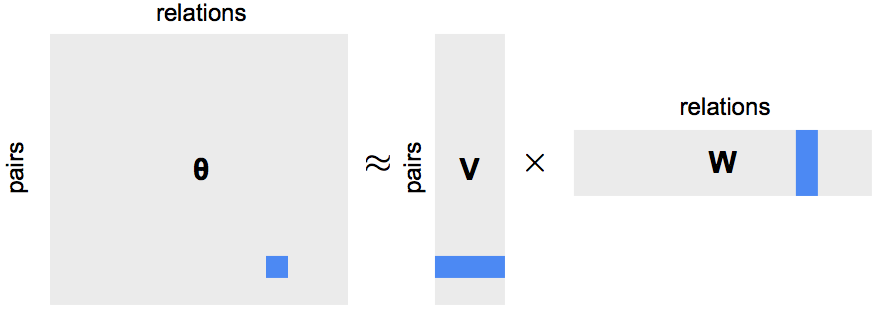

* **Training instance**: consists of a surface pattern or KB relation $\mathcal{r_{pos}}$ and an entity pair  $\mathcal{e_{pos}}$ the relation co-occurs with, as well as a relation $\mathcal{r_{neg}}$ and a entity pair $\mathcal{e_{neg}}$ that do not co-occur in the training data
* **Positive relations and entity pairs**: directly taken from the annotated data
* **Negative entity pairs and relations**: *sampled randomly* from data points which are represented by the empty cell in the matrix above

In [329]:
# data reading
training_sents, training_entpairs, training_labels = ie.readLabelledData()

# split positive and negative training data
pos_train_ids, neg_train_ids = ie.split_labels_pos_neg(training_labels + training_labels)

training_toks_pos = [t.split(" ") for i, t in enumerate(training_sents + training_labels) if i in pos_train_ids]
training_toks_neg = [t.split(" ") for i, t in enumerate(training_sents + training_labels) if i in neg_train_ids]

training_ent_toks_pos = [" || ".join(t).split(" ") for i, t in enumerate(training_entpairs + training_entpairs) if i in pos_train_ids]
training_ent_toks_neg = [" || ".join(t).split(" ") for i, t in enumerate(training_entpairs + training_entpairs) if i in neg_train_ids]
testing_ent_toks = [" || ".join(t).split(" ") for t in testing_entpairs]

# print length statistics
lens_rel = [len(s) for s in training_toks_pos + training_toks_neg]
lens_ents = [len(s) for s in training_ent_toks_pos + training_ent_toks_neg + testing_ent_toks]
print("Max relation length:", max(lens_rel))
print("Max entity pair length:", max(lens_ents))

Max relation length: 16
Max entity pair length: 9


In [330]:
# vectorise data (assign IDs to words)
count_rels, dictionary_rels, reverse_dictionary_rels = ie.build_dataset(
        [token for senttoks in training_toks_pos + training_toks_neg for token in senttoks])

count_ents, dictionary_ents, reverse_dictionary_ents = ie.build_dataset(
        [token for senttoks in training_ent_toks_pos + training_ent_toks_neg for token in senttoks])

print(reverse_dictionary_rels)

Final vocab size: 163
Final vocab size: 138
{0: 'UNK', 1: 'XXXXX', 2: 'for', 3: 'used', 4: 'method', 5: 'task', 6: 'NONE', 7: 'the', 8: 'a', 9: 'of', 10: 'and', 11: 'to', 12: 'is', 13: 'in', 14: 'are', 15: 'model', 16: 'proposed', 17: 'we', 18: 'this', 19: 'new', 20: 'presented', 21: 'as', 22: 'with', 23: 'propose', 24: 'pso-based', 25: 'anfis', 26: 'approaches', 27: 'affective', 28: 'combination', 29: '(', 30: ')', 31: 'on', 32: 'using', 33: 'demonstrates', 34: 'paper', 35: 'proposes', 36: 'solve', 37: 'design', 38: 'an', 39: 'swarm', 40: 'intelligence', 41: 'introduced', 42: 'clustering', 43: 'techniques', 44: 'text', 45: 'mining', 46: 'building', 47: 'able', 48: 'enhance', 49: 'fully', 50: '3d', 51: 'buildings', 52: 'two', 53: 'more', 54: 'capable', 55: 'product', 56: 'customer', 57: 'satisfaction', 58: 'solved', 59: 'obtained', 60: 'optimal', 61: 'section', 62: 'shape', 63: 'sizing', 64: 'cable–truss', 65: 'structures', 66: 'employed', 67: 'assists', 68: 'chaos', 69: 'theory', 70: 

In [331]:
# transform sentences to IDs, pad vectors for each sentence so they have same length
rels_train_pos = [ie.transform_dict(dictionary_rels, senttoks, max(lens_rel)) for senttoks in training_toks_pos]
rels_train_neg = [ie.transform_dict(dictionary_rels, senttoks, max(lens_rel)) for senttoks in training_toks_neg]
ents_train_pos = [ie.transform_dict(dictionary_ents, senttoks, max(lens_ents)) for senttoks in training_ent_toks_pos]
ents_train_neg = [ie.transform_dict(dictionary_ents, senttoks, max(lens_ents)) for senttoks in training_ent_toks_neg]

print(rels_train_pos[0], "\n", rels_train_pos[1])

[33  1 10 42 43  2  1  0  0  0  0  0  0  0  0  0] 
 [33 44 45 10  1  2 46  1  0  0  0  0  0  0  0  0]


In [332]:
# Negatively sample some entity pairs for training. Here we have some manually labelled neg ones, so we can sample from them.
ents_train_neg_samp = [random.choice(ents_train_neg) for _ in rels_train_neg]
    
ents_test_pos = [ie.transform_dict(dictionary_ents, senttoks, max(lens_ents)) for senttoks in testing_ent_toks]
# Sample those test entity pairs from the training ones as for those we have neg annotations
ents_test_neg_samp = [random.choice(ents_train_neg) for _ in ents_test_pos]  

vocab_size_rels = len(dictionary_rels)
vocab_size_ents = len(dictionary_ents) 

# for testing, we want to check if each unlabelled instance expresses the given relation "method for task"
rels_test_pos = [ie.transform_dict(dictionary_rels, training_toks_pos[-1], max(lens_rel)) for _ in testing_patterns]
rels_test_neg_samp = [random.choice(rels_train_neg) for _ in rels_test_pos]

In [333]:
data = ie.vectorise_data(training_sents, training_entpairs, training_labels, testing_patterns, testing_entpairs)

rels_train_pos, rels_train_neg, ents_train_pos, ents_train_neg_samp, rels_test_pos, rels_test_neg_samp, \
    ents_test_pos, ents_test_neg_samp, vocab_size_rels, vocab_size_ents, max_lens_rel, max_lens_ents, \
    dictionary_rels_rev, dictionary_ents_rev = data
  
# setting hyper-parameters
batch_size = 4
repr_dim = 30 # dimensionality of relation and entity pair vectors
learning_rate = 0.001
max_epochs = 31

Max relation length: 16
Max entity pair length: 9
Final vocab size: 163
Final vocab size: 138


In [334]:
def create_model_f_reader(max_rel_seq_length, max_cand_seq_length, repr_dim, vocab_size_rels, vocab_size_cands):
    """
    Create a Model F Universal Schema reader (Tensorflow graph).
    Args:
        max_rel_seq_length: maximum sentence sequence length
        max_cand_seq_length: maximum candidate sequence length
        repr_dim: dimensionality of vectors
        vocab_size_rels: size of relation vocabulary
        vocab_size_cands: size of candidate vocabulary
    Returns:
        dotprod_pos: dot product between positive entity pairs and relations
        dotprod_neg: dot product between negative entity pairs and relations
        diff_dotprod: difference in dot product of positive and negative instances, used for BPR loss (optional)
        [relations_pos, relations_neg, ents_pos, ents_neg]: placeholders, fed in during training for each batch
    """

In [335]:
# Placeholders (empty Tensorflow variables) for positive and negative relations and entity pairs
# In each training epoch, for each batch, those will be set through mini batching

relations_pos = tf.placeholder(tf.int32, [None, max_lens_rel], name='relations_pos')  # [batch_size, max_rel_seq_len]
relations_neg = tf.placeholder(tf.int32, [None, max_lens_rel], name='relations_neg')  # [batch_size, max_rel_seq_len]

ents_pos = tf.placeholder(tf.int32, [None, max_lens_ents], name="ents_pos") # [batch_size, max_ent_seq_len]
ents_neg = tf.placeholder(tf.int32, [None, max_lens_ents], name="ents_neg") # [batch_size, max_ent_seq_len]

In [336]:
# Creating latent representations of relations and entity pairs
# latent feature representation of all relations, which are initialised randomly
relation_embeddings = tf.Variable(tf.random_uniform([vocab_size_rels, repr_dim], -0.1, 0.1, dtype=tf.float32),
                                   name='rel_emb', trainable=True)

# latent feature representation of all entity pairs, which are initialised randomly
ent_embeddings = tf.Variable(tf.random_uniform([vocab_size_ents, repr_dim], -0.1, 0.1, dtype=tf.float32),
                                      name='cand_emb', trainable=True)

# look up latent feature representation for relations and entities in current batch
rel_encodings_pos = tf.nn.embedding_lookup(relation_embeddings, relations_pos)
rel_encodings_neg = tf.nn.embedding_lookup(relation_embeddings, relations_neg)

ent_encodings_pos = tf.nn.embedding_lookup(ent_embeddings, ents_pos)
ent_encodings_neg = tf.nn.embedding_lookup(ent_embeddings, ents_neg)

In [337]:
# our feature representation here is a vector for each word in a relation or entity 
# because our training data is so small
# we therefore take the sum of those vectors to get a representation of each relation or entity pair
rel_encodings_pos = tf.reduce_sum(rel_encodings_pos, 1)  # [batch_size, num_rel_toks, repr_dim]
rel_encodings_neg = tf.reduce_sum(rel_encodings_neg, 1)  # [batch_size, num_rel_toks, repr_dim]

ent_encodings_pos = tf.reduce_sum(ent_encodings_pos, 1)  # [batch_size, num_ent_toks, repr_dim]
ent_encodings_neg = tf.reduce_sum(ent_encodings_neg, 1)  # [batch_size, num_ent_toks, repr_dim]

In [338]:
# measuring compatibility between positive entity pairs and relations
# used for ranking test data
dotprod_pos = tf.reduce_sum(tf.multiply(ent_encodings_pos, rel_encodings_pos), 1)

# measuring compatibility between negative entity pairs and relations
dotprod_neg = tf.reduce_sum(tf.multiply(ent_encodings_neg, rel_encodings_neg), 1)

# difference in dot product of positive and negative instances
# used for BPR loss (ranking loss)
diff_dotprod = tf.reduce_sum(tf.multiply(ent_encodings_pos, rel_encodings_pos) - tf.multiply(ent_encodings_neg, rel_encodings_neg), 1)


To train this model, we define a loss, which tries to maximise the distance between the positive and negative instances. One possibility of this is the logistic loss.

$\mathcal{\sum -  log(v_{e_{pos}} * a_{r_{pos}})} + {\sum log(v_{e_{neg}} * a_{r_{neg}}))}$

Now that we have read in the data, vectorised it and created the universal schema relation extraction model, let's start training

In [339]:
# create a the model / Tensorflow computation graph
dotprod_pos, dotprod_neg, diff_dotprod, placeholders = ie.create_model_f_reader(max_lens_rel, max_lens_ents, repr_dim, vocab_size_rels,
                          vocab_size_ents)

# logistic loss
loss = tf.reduce_sum(tf.nn.softplus(-dotprod_pos)+tf.nn.softplus(dotprod_neg))

# alternative: BPR loss
#loss = tf.reduce_sum(tf.nn.softplus(diff_dotprod))

In [340]:
data = [np.asarray(rels_train_pos), np.asarray(rels_train_neg), np.asarray(ents_train_pos), np.asarray(ents_train_neg_samp)]
data_test = [np.asarray(rels_test_pos), np.asarray(rels_test_neg_samp), np.asarray(ents_test_pos), np.asarray(ents_test_neg_samp)]

# define an optimiser. Here, we use the Adam optimiser
optimizer = tf.train.AdamOptimizer(learning_rate)
    
# training with mini-batches
batcher = tfutil.BatchBucketSampler(data, batch_size)
batcher_test = tfutil.BatchBucketSampler(data_test, 1, test=True)

In [341]:
with tf.Session() as sess:
    trainer = tfutil.Trainer(optimizer, max_epochs)
    trainer(batcher=batcher, placeholders=placeholders, loss=loss, session=sess)

    # we obtain test scores
    test_scores = trainer.test(batcher=batcher_test, placeholders=placeholders, model=tf.nn.sigmoid(dotprod_pos), session=sess)

Epoch  1 	Loss  58.2945766449
Epoch  2 	Loss  42.8228156567
Epoch  3 	Loss  32.8716278076
Epoch  4 	Loss  24.9985466003
Epoch  5 	Loss  19.7333737612
Epoch  6 	Loss  14.6670723557
Epoch  7 	Loss  11.8241870403
Epoch  8 	Loss  8.2941237092
Epoch  9 	Loss  6.41954058409
Epoch  10 	Loss  5.47933986783
Epoch  11 	Loss  4.4851039052
Epoch  12 	Loss  3.63774502277
Epoch  13 	Loss  2.97257561982
Epoch  14 	Loss  2.31174084544
Epoch  15 	Loss  2.01734363288
Epoch  16 	Loss  1.75664272904
Epoch  17 	Loss  1.53199803457
Epoch  18 	Loss  1.3177568242
Epoch  19 	Loss  1.21278239228
Epoch  20 	Loss  1.04362636805
Epoch  21 	Loss  0.947058934718
Epoch  22 	Loss  0.853188619018
Epoch  23 	Loss  0.752859611064
Epoch  24 	Loss  0.683341357857
Epoch  25 	Loss  0.627710720524
Epoch  26 	Loss  0.572402523831
Epoch  27 	Loss  0.564070399851
Epoch  28 	Loss  0.508267262951
Epoch  29 	Loss  0.459860412404
Epoch  30 	Loss  0.418545652181


In [342]:
# show predictions
ents_test = [ie.reverse_dict_lookup(dictionary_ents_rev, e) for e in ents_test_pos]
rels_test = [ie.reverse_dict_lookup(dictionary_rels_rev, r) for r in rels_test_pos]
testresults = sorted(zip(test_scores, ents_test, rels_test), key=lambda t: t[0], reverse=True)  # sort for decreasing score

print("\nTest predictions by decreasing probability:")
for score, tup, rel in testresults:
    print('%f\t%s\tREL\t%s' % (score, " ".join(tup), " ".join(rel)))


Test predictions by decreasing probability:
0.999814	genetic algorithm || search algorithm	REL	method used for task
0.999814	UNK search algorithm || genetic algorithm	REL	method used for task
0.999765	subtractive clustering || genetic algorithm	REL	method used for task
0.999596	UNK search || hybrid genetic algorithm	REL	method used for task
0.999580	genetic algorithm || local search	REL	method used for task
0.999570	genetic algorithm || ensemble	REL	method used for task
0.999559	genetic algorithm || optimization problem	REL	method used for task
0.999559	optimization problem || genetic algorithm	REL	method used for task
0.999559	optimization problem || genetic algorithm	REL	method used for task
0.999508	genetic algorithm || UNK algorithm	REL	method used for task
0.999508	UNK algorithm || genetic algorithm	REL	method used for task
0.999508	UNK algorithm || genetic algorithm	REL	method used for task
0.999508	UNK algorithm || genetic algorithm	REL	method used for task
0.999480	UNK search 

0.904637	UNK UNK || UNK UNK techniques	REL	method used for task
0.904637	UNK UNK || UNK UNK techniques	REL	method used for task
0.904637	UNK UNK techniques || UNK	REL	method used for task
0.904637	UNK UNK || UNK techniques	REL	method used for task
0.904637	UNK UNK || UNK techniques	REL	method used for task
0.904637	UNK UNK || UNK techniques	REL	method used for task
0.904374	linear UNK || solution algorithm	REL	method used for task
0.902402	UNK UNK || surrogate model	REL	method used for task
0.902357	problem UNK || UNK UNK design	REL	method used for task
0.902320	UNK algorithm || wind	REL	method used for task
0.900853	genetic UNK || UNK regression	REL	method used for task
0.900581	UNK UNK UNK || chain	REL	method used for task
0.900505	computational UNK || UNK algorithm	REL	method used for task
0.900505	UNK algorithm || computational	REL	method used for task
0.900505	UNK algorithm || computational	REL	method used for task
0.900057	dynamic analysis || UNK method	REL	method used for task
0

0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || UNK	REL	method used for task
0.787030	UNK UNK || 

Test prediction probabilities are obtained by scoring each test instances with:

$\mathcal{ \sigma  ( v_{e} * a_{r} )}$

* Note that as input for the latent feature representation, we discarded words that only appeared twice
    * Hence, for those words we did not learn a representation, denoted here by 'UNK'
* This is also typically done for other feature representations, as if we only see a feature once, it is difficult to learn weights for it

**Thought Exercises**: 
* The scores shown here are for the relation 'method used for task'. However, we could also use our model to score the compatibility of entity pairs with other relations, e.g. 'demonstrates XXXXX for XXXXXX'. How could this be done here?
* How could we get around the problem of unseen words, as described above?
* What other possible problems can you see with the above formulation of universal schema relation extraction?
* What possible problems can you see with using latent word representations?

Enter answer: https://tinyurl.com/yytql7wh

## Summary

Various relation extraction techniques:
* Pattern-based extraction
* Bootstrapping
* Supervised
* Distantly supervised extraction
* Universal schema

Features often a mix of 
* Syntax-based (relation path)
* Representation learning based (word/sentence embedding)

## Background Material

* Jurafky, Dan and Martin, James H. (2016). Speech and Language Processing, Chapter 17 (Information Extraction): https://web.stanford.edu/~jurafsky/slp3/17.pdf

* Riedel, Sebastian and Yao, Limin and McCallum, Andrew and Marlin, Benjamin M. (2013). Relation extraction with Matrix Factorization and Universal Schemas. Proceedings of NAACL.  http://www.aclweb.org/anthology/N13-1008

## Further Reading

* Alex Ratner, Stephen Bach, Paroma Varma, Chris Ré (2018). Weak Supervision: The New Programming Paradigm for Machine Learning. https://hazyresearch.github.io/snorkel/blog/ws_blog_post.html
    * Have a look at this for details on weak supervision and pointers to methods for learning with limited labelled data
* Quan Wang, Zhendong Mao, Bin Wang, and Li Guo (2017). Knowledge Graph Embedding: A Survey of Approaches and Applications. https://persagen.com/files/misc/Wang2017Knowledge.pdf
    * Have a look at this for more scoring functions for universal schema relation extraction
* Shantanu Kumar (2017). A Survey of Deep Learning Methods for Relation Extraction. https://arxiv.org/pdf/1705.03645.pdf
* Awesome relation extraction, curated list of resources on relation extraction. https://github.com/roomylee/awesome-relation-extraction